In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.linear_model import LinearRegression, Lasso

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import explained_variance_score, mean_squared_error, r2_score

In [15]:
train = pd.read_csv("train.csv", na_values=['na'])
test = pd.read_csv("test.csv", na_values=['na'])
train.shape, test.shape

((30000, 44), (23333, 44))

In [16]:
unlabeled = pd.read_csv("unlabeled_v2.csv", na_values=['na'])
unlabeled.shape

(23333, 43)

###  Functions

In [4]:
bands_all = ['u', 'g', 'r', 'i', 'z']
indx_all = ['0', '1', '2', '3', '4', '5', '6']

In [5]:
def show_missing_values():
    missing_values_df = pd.DataFrame(0, columns=['train', 'test', 'unlabeled'], index=train.columns)

    missing_values_df['train'] = train.isna().sum()

    missing_values_df['unlabeled'] = unlabeled.isna().sum()
    missing_values_df.at['class', 'unlabeled'] = 0
    missing_values_df.unlabeled = missing_values_df.unlabeled.astype('int64')

    missing_values_df['test'] = test.isna().sum()

    return missing_values_df[missing_values_df.any(axis=1)]

In [6]:
def show_classes_distributions_by_index(idx, data):    
    fig, ax = plt.subplots(1, 5, figsize=(10, 3))
    fig.subplots_adjust(wspace=0.7)

    for j in range(5):
        f_name = "{}_{}".format(bands_all[j], idx)
        sns.boxplot(x='class', y=f_name, data=data, ax=ax[j])

# Data Exploration

In [7]:
train.head()

,objid,ra,dec,u_0,g_0,r_0,i_0,z_0,clean,rowc,...,g_5,r_5,i_5,z_5,u_6,g_6,r_6,i_6,z_6,class
0,78023,121.079395,-9.343143,25.46583,22.53827,21.52258,NaN,NaN,1,107.03430,...,-0.184090,-0.054633,NaN,NaN,6,5,6,5,2,0
1,67239,121.080753,-9.339397,23.64559,24.57786,21.76326,20.94348,21.52855,1,134.68570,...,0.371713,-0.128548,-0.122364,NaN,6,8,1,1,0,0
2,48461,121.070386,-9.332728,24.88126,23.49473,22.23877,21.38574,21.51635,1,84.76380,...,0.004125,0.014147,-0.051568,NaN,6,4,6,4,5,0
3,55564,121.083052,-9.334026,23.57384,21.42411,20.43948,19.99905,19.82959,1,177.05670,...,-0.080959,NaN,-0.089301,NaN,3,4,5,2,4,0
4,96180,121.063351,-9.325032,23.85167,20.25245,19.60670,19.18877,19.08231,1,65.37769,...,-0.037828,-0.097120,NaN,0.106472,3,4,7,6,3,0


In [8]:
train['class'].value_counts()

2    10000
1    10000
0    10000
Name: class, dtype: int64

## Missing values

In [9]:
show_missing_values()

,train,test,unlabeled
u_0,4556,3455,0
g_0,4504,3460,0
r_0,4555,3380,0
i_0,4596,3449,0
z_0,4481,3499,0
rowv,401,681,621
colv,401,681,621
u_3,5173,4836,4935
g_3,1720,1690,1760
r_3,727,752,778


Unlabeled data has less missing values then training and testing sets.  
Columns '-0', '-3', '-4', '-5' in training set has ~13-15% missing values.  
  
  Check if these columns has influence on class prediction

In [17]:
color_columns = ["{}_{}".format(b, i) for b in bands_all for i in indx_all]

train_colors = train[[*color_columns, 'class']]
unlabeled_colors = unlabeled[[*color_columns]]

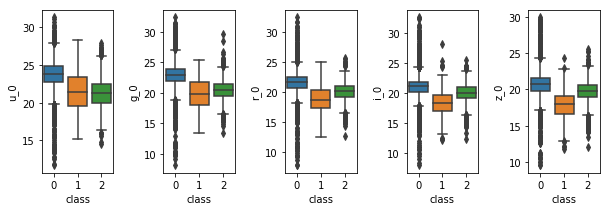

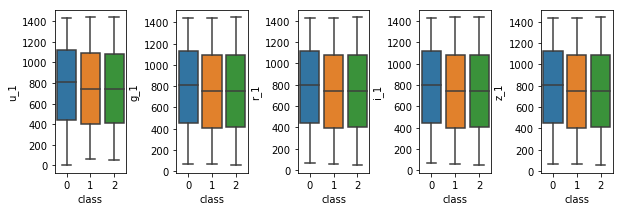

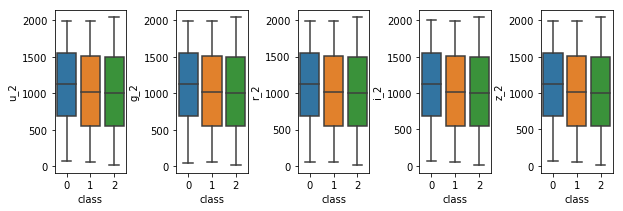

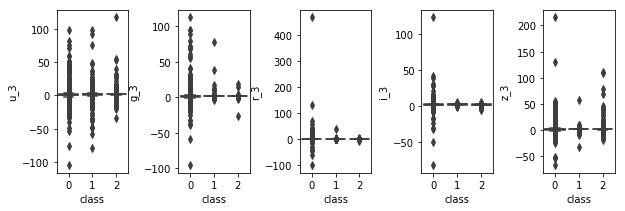

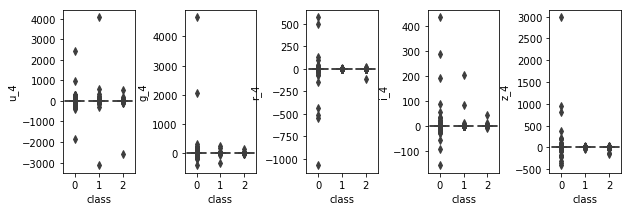

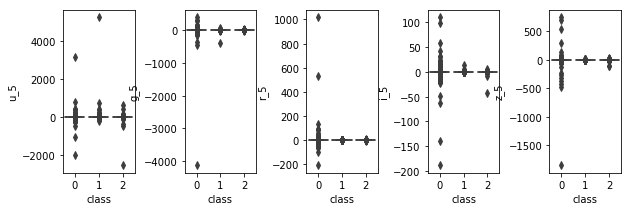

In [18]:
# plot only features which has real-type values
for i in ['0', '1', '2', '3', '4', '5']:
    show_classes_distributions_by_index(i, train_colors)

3-rd, 4-th and 5-th features seem to have small distribution and no effect on class (and have a lot of outliers)   
To be sure let's investigate outliers and check again  
For now let's consider them safe to delete.    

0-th feature has a bit differrent values for differrent classes, so let's investigate it more.  


#### 0-th color features

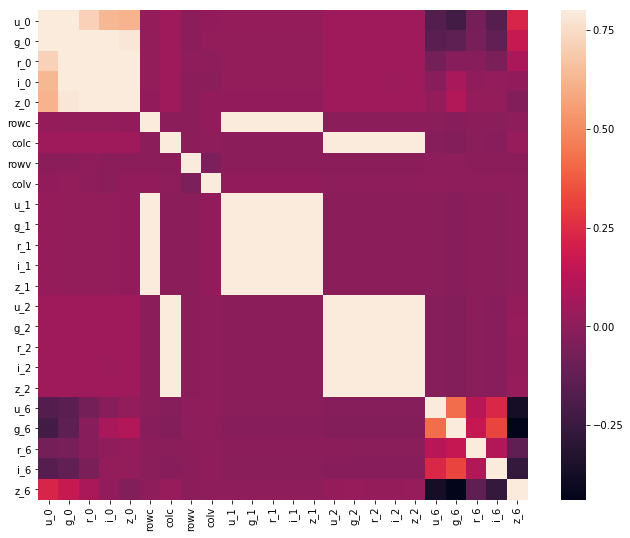

In [19]:
ns = ['3', '4', '5']
exclude_from_corrmap = ["{}_{}".format(b, n) for n in ns for b in bands_all]
exclude_from_corrmap.extend(['class', 'objid', 'ra', 'dec', 'clean'])

corrmat = train.drop(exclude_from_corrmap, axis=1).corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8, square=True)

0-th features in training set have strong corrlation with one another. ('u_0' and 'g_0', 'g_0' and 'r_0' and so on)  

Check the same in unlabeled dataset

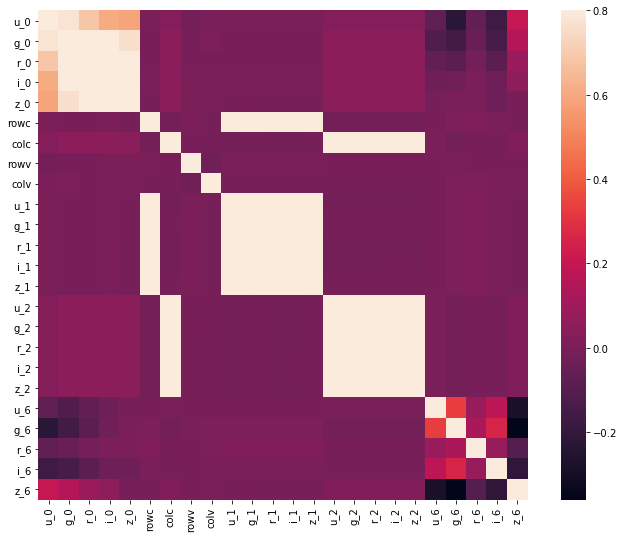

In [20]:
exclude_from_corrmap.remove('class')

corrmat = unlabeled.drop(exclude_from_corrmap, axis=1).corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8, square=True)

Check how many 0-th features are missing at the same time in train dataset

0    13266
1    11664
2     4248
3      764
4       50
5        8
dtype: int64


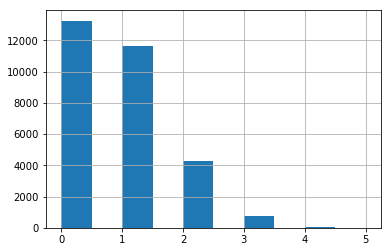

In [21]:
zeros_features = ["{}_0".format(b) for b in bands_all]
num_of_missing_0th = train[zeros_features].isna().sum(axis=1)

print(num_of_missing_0th.value_counts())
num_of_missing_0th.hist()

A few samples have all 0-th features missing, so after 'smart' prediction we still have to fill NaNs with mean values.

In [22]:
train[zeros_features].corr()

,u_0,g_0,r_0,i_0,z_0
u_0,1.000000,0.817264,0.717657,0.631143,0.617691
g_0,0.817264,1.000000,0.901610,0.816336,0.782590
r_0,0.717657,0.901610,1.000000,0.931553,0.873073
i_0,0.631143,0.816336,0.931553,1.000000,0.896410
z_0,0.617691,0.782590,0.873073,0.896410,1.000000


In [23]:
unlabeled[zeros_features].corr()

,u_0,g_0,r_0,i_0,z_0
u_0,1.000000,0.775498,0.682887,0.605890,0.590848
g_0,0.775498,1.000000,0.898527,0.816628,0.768118
r_0,0.682887,0.898527,1.000000,0.915039,0.853865
i_0,0.605890,0.816628,0.915039,1.000000,0.866295
z_0,0.590848,0.768118,0.853865,0.866295,1.000000


Prediction of every feature should be based on the most correlated variable:
* u_0 based on g_0  
* g_0 based on r_0  
* r_0 based on i_0  
* i_0 based on r_0  
* z_0 based on i_0  

In [24]:
def fill_nans_based_on_regression(col, based_on_col, data):
    print("\n{} based on {}".format(col, based_on_col))
    
    # get only notna values to train linear regression
    clean_columns_mask = data[[col, based_on_col]].notna().all(axis=1)
    clean_columns = data[clean_columns_mask][[col, based_on_col]]
    
    # get samples where 'col' is NaN and 'based_col' is not NaN
    # (samples, where 'col' value will be predicted)
    col_nan_mask = data[col].isna()
    based_col_notna_mask = data[based_on_col].notna()
    samples_to_predict = data[col_nan_mask & based_col_notna_mask]
    
    # reshape to fit the regression
    X = clean_columns[based_on_col].values.reshape(-1, 1)
    y = clean_columns[col].values.reshape(-1, 1)
    to_predict = samples_to_predict[based_on_col].values.reshape(-1, 1)
    
    reg = LinearRegression()
    reg.fit(X, y)
    print("reg score: {}".format(reg.score(X, y)))
    
    predicted = reg.predict(to_predict).flatten()
    
    num_of_nans_before = data[col].isna().sum()
    
    # fill predicted values instead of NaNs
    idx = samples_to_predict.index
    data.loc[idx, col] = predicted
    
    num_of_nans_after = data[col].isna().sum()
    print("replaced {} NaN values".format(num_of_nans_before - num_of_nans_after))

In [27]:
replacement_scheme = [('r_0', 'i_0'), ('i_0', 'r_0'), ('z_0', 'r_0'), ('g_0', 'r_0'), ('u_0', 'g_0')]

for col, based_on_col in replacement_scheme:
    fill_nans_based_on_regression(col, based_on_col, train)

for col, based_on_col in replacement_scheme:
    fill_nans_based_on_regression(col, based_on_col, test)


r_0 based on i_0
reg score: 0.8677907744593449
replaced 3885 NaN values

i_0 based on r_0
reg score: 0.8856728999444379
replaced 3926 NaN values

z_0 based on r_0
reg score: 0.7625302248742643
replaced 4377 NaN values

g_0 based on r_0
reg score: 0.7919346700916082
replaced 4402 NaN values

u_0 based on g_0
reg score: 0.6422382303904675
replaced 4540 NaN values

r_0 based on i_0
reg score: 0.8407839811848895
replaced 2854 NaN values

i_0 based on r_0
reg score: 0.8608835564380372
replaced 2923 NaN values

z_0 based on r_0
reg score: 0.7446820857487215
replaced 3416 NaN values

g_0 based on r_0
reg score: 0.8010923400872132
replaced 3376 NaN values

u_0 based on g_0
reg score: 0.5750493514492977
replaced 3440 NaN values


In [28]:
show_missing_values()

,train,test,unlabeled
u_0,16,15,0
g_0,102,84,0
r_0,670,526,0
i_0,670,526,0
z_0,104,83,0
rowv,401,681,621
colv,401,681,621
u_3,5173,4836,4935
g_3,1720,1690,1760
r_3,727,752,778


Fill all the rest 0-th features with mean values by columns

In [33]:
train[zeros_features] = train[zeros_features].fillna(train[zeros_features].mean())
test[zeros_features] = test[zeros_features].fillna(test[zeros_features].mean())

train[zeros_features].isna().sum().max(), test[zeros_features].isna().sum().max() 

(0, 0)

#### 3-rd, 4-th and 5-th color features

In [30]:
# eventually delete 3-rd, 4-th and 5-th features 
bands = ['u', 'g', 'r', 'i', 'z']
indx = ['3', '4', '5']
columns_to_drop = ["{}_{}".format(b, i) for b in bands for i in indx]

train = train.drop(columns_to_drop, axis=1)
test = test.drop(columns_to_drop, axis=1)

unlabeled = unlabeled.drop(columns_to_drop, axis=1)

#### colv and rowv features

For now we have only 'rowv' and 'colv' missing values  

In [34]:
show_missing_values()

,train,test,unlabeled
rowv,401,681,621
colv,401,681,621


In [35]:
train[['rowv', 'colv']].isna().all(axis=1).value_counts()

False    29599
True       401
dtype: int64

In [36]:
unlabeled[['rowv', 'colv']].isna().all(axis=1).value_counts()

False    22712
True       621
dtype: int64

Columns are both missing or both present in train and unlabeled datasets. Assume, the same situation is in the test set.   
       
Check if they are relevant to class prediction and if we can determine them from other features

In [37]:
train_clean = train[train.notna().all(axis=1)]
unlabeled_clean = unlabeled[unlabeled.notna().all(axis=1)]    

Since 'rowv' and 'colv' columns describe object velocity in frame it's not worth to check relationship with all other features.  
I'll check only 'rowc','colc' - object coordinates if frame

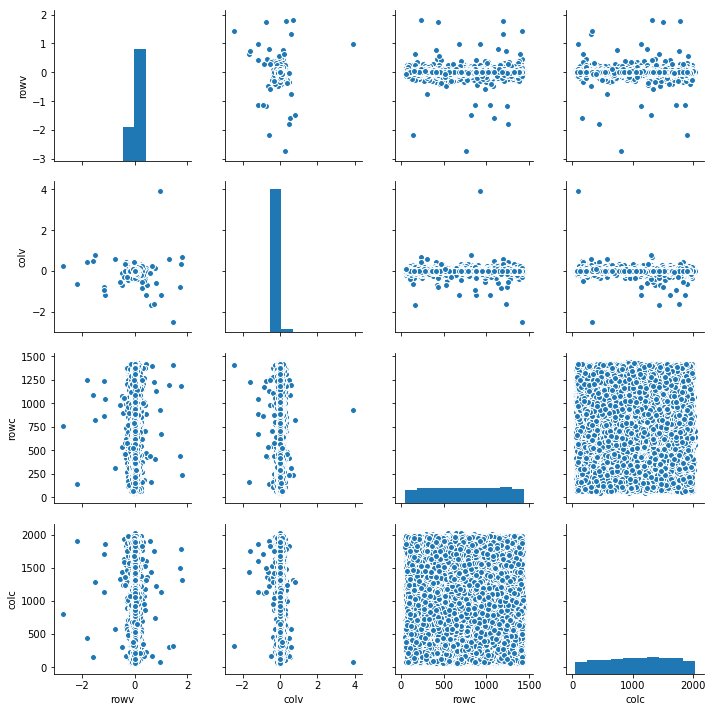

In [38]:
df = unlabeled_clean[['rowv', 'colv', 'rowc','colc']]
sns.pairplot(df)

No relationship with other features.  
Let's check it's influence on class prediction. 

In [39]:
train_clean.groupby('class')[['rowv', 'colv']].agg({'mean', 'std', 'count'})

rowv                      colv                    
      count       std      mean count       std      mean
class                                                    
0      9607  0.070881  0.000052  9607  0.064285  0.000790
1      9999  0.016655  0.000049  9999  0.017225  0.000149
2      9993  0.012842  0.000260  9993  0.009462  0.000926

In [120]:
train[['rowv', 'colv']].mean()

rowv    0.000121
colv    0.000619
dtype: float64

In [121]:
unlabeled[['rowv', 'colv']].mean()

rowv    0.000248
colv    0.000291
dtype: float64

In [90]:
test[['rowv', 'colv']].mean()

rowv    0.000254
colv   -0.000360
dtype: float64


Columns has similar values in all classes, so fill NaN values with mean by dataset  

In [91]:
train.fillna(train.mean(), inplace=True)
test.fillna(test.mean(), inplace=True)

In [122]:
train.isna().sum().max(), test.isna().sum().max()

(0, 0)

In [92]:
train.shape, test.shape

((30000, 24), (23333, 24))

### Conclusion

*  Drop  '-3', '-4', '-5'  columns due to ~13-15% of missing values 
*  Fill '-0' columns with regression results based on present '-0' features
*  Fill all remaining '-0' NaNs with mean values
*  Replace 'rowv' and 'colv' NaNs with mean values